# <font color=#025dfa> Derin Öğrenme Regresyon ile Yengeç Yaş Tahmini - Crab Age Estimation with Deep Learning Regression

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, yengeçlerin biyolojik özelliklerine dayalı olarak yaş tahmini yapmak için derin öğrenme tabanlı bir regresyon modeli geliştirmeyi hedeflemektedir. Yengeçlerin boyutları, ağırlıkları, cinsiyetleri ve diğer fiziksel özellikleri kullanılarak yaşları tahmin edilecektir. Proje, deniz biyolojisi ve ekoloji çalışmalarında daha doğru yaş tahminleri yaparak popülasyon dinamiklerini anlamaya ve yengeçlerin korunmasına yönelik önemli veriler sunmayı amaçlamaktadır.

EN = This project aims to develop a deep learning-based regression model to estimate the age of crabs based on their biological characteristics. Ages of crabs will be estimated using their size, weight, sex and other physical characteristics. The project aims to provide important data for understanding population dynamics and conservation of crabs by making more accurate age estimates in marine biology and ecology studies.

Kaynak/Source = https://www.kaggle.com/competitions/crab-age-regression-dataset-ai-generated-insights

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import nltk
import math
import warnings
warnings.filterwarnings('ignore')
import pickle
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
pd.set_option("display.max_columns",None) 
# TR = En fazla kaç sütun olduğunu gösteriyor. 
# EN = It shows the maximum number of columns.

In [3]:
df=pd.read_csv('train.csv')

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis 

In [4]:
df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,0.8250,0.6375,0.2250,5.613201,2.069513,1.587572,1.700970,6.0
1,1,M,1.5250,1.1250,0.3875,30.036295,11.453198,6.307764,9.213587,11.0
2,2,I,0.7750,0.5625,0.1750,3.642911,1.445825,0.878834,1.133980,6.0
3,3,F,1.3125,1.0125,0.3125,16.853778,7.243297,3.515338,5.102910,10.0
4,4,F,1.5000,1.2125,0.4750,32.162508,14.926012,7.526792,8.930093,13.0


In [5]:
df.sample(5)

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
751,751,I,0.3750,0.3250,0.0625,0.510291,0.184272,0.184272,0.141747,4.0
7460,7460,F,1.1875,0.9125,0.2875,14.373197,6.832230,2.934173,4.394172,9.0
2491,2491,M,1.1375,0.8750,0.3250,13.395139,5.712424,2.990872,4.677668,8.0
1878,1878,I,1.1750,0.9375,0.3125,14.500769,6.988152,3.047571,4.139027,7.0
1919,1919,I,1.3750,1.0875,0.3625,21.999212,8.419802,5.187958,6.378637,9.0


In [6]:
df.tail()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
14995,14995,M,1.6750,1.3000,0.4375,44.879013,16.499409,10.701936,16.017467,20.0
14996,14996,M,1.4750,1.1500,0.3875,27.924257,13.324265,5.698250,7.654365,13.0
14997,14997,I,1.1125,0.8000,0.2500,11.594945,5.244657,2.579804,3.827183,7.0
14998,14998,M,1.0875,0.8125,0.2625,10.730286,4.309124,2.579804,3.401940,14.0
14999,14999,F,1.7000,1.2875,0.4250,36.457457,17.279020,8.178831,8.930093,10.0


In [7]:
df.shape

(15000, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              15000 non-null  int64  
 1   Sex             15000 non-null  object 
 2   Length          15000 non-null  float64
 3   Diameter        15000 non-null  float64
 4   Height          15000 non-null  float64
 5   Weight          15000 non-null  float64
 6   Shucked Weight  15000 non-null  float64
 7   Viscera Weight  15000 non-null  float64
 8   Shell Weight    15000 non-null  float64
 9   Age             15000 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.1+ MB


In [9]:
df.fillna(0, inplace=True)

In [10]:
df.isnull().sum().sort_values(ascending=False)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [11]:
df.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.312110,1.019690,0.345968,23.045341,9.930548,4.979249,6.614761,9.950133
std,4330.271354,0.288489,0.237534,0.090938,12.547790,5.553554,2.771789,3.551039,3.223736
min,0.000000,0.225000,0.000000,0.000000,0.184272,0.070874,0.028349,0.012814,1.000000
25%,3749.750000,1.137500,0.875000,0.287500,13.154168,5.613201,2.778251,3.827183,8.000000
50%,7499.500000,1.375000,1.075000,0.362500,23.487561,9.837276,4.861939,6.803880,9.000000
75%,11249.250000,1.525000,1.200000,0.412500,31.992411,13.877080,6.973977,9.000966,11.000000
max,14999.000000,2.000000,1.650000,0.625000,72.432973,35.139205,16.286788,28.491248,29.000000


In [12]:
df.corr(numeric_only=True)

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,1.000000,0.001121,0.001803,-0.000498,-0.001470,0.000368,-0.001601,-0.003517,0.003106
Length,0.001121,1.000000,0.991882,0.936477,0.938286,0.915564,0.921764,0.919118,0.622534
Diameter,0.001803,0.991882,1.000000,0.939165,0.940479,0.914374,0.922959,0.925165,0.630463
Height,-0.000498,0.936477,0.939165,1.000000,0.919593,0.878369,0.903315,0.922033,0.663520
Weight,-0.001470,0.938286,0.940479,0.919593,1.000000,0.970472,0.974015,0.967309,0.616414
Shucked Weight,0.000368,0.915564,0.914374,0.878369,0.970472,1.000000,0.947248,0.909437,0.506192
Viscera Weight,-0.001601,0.921764,0.922959,0.903315,0.974015,0.947248,1.000000,0.938615,0.584567
Shell Weight,-0.003517,0.919118,0.925165,0.922033,0.967309,0.909437,0.938615,1.000000,0.685442
Age,0.003106,0.622534,0.630463,0.663520,0.616414,0.506192,0.584567,0.685442,1.000000


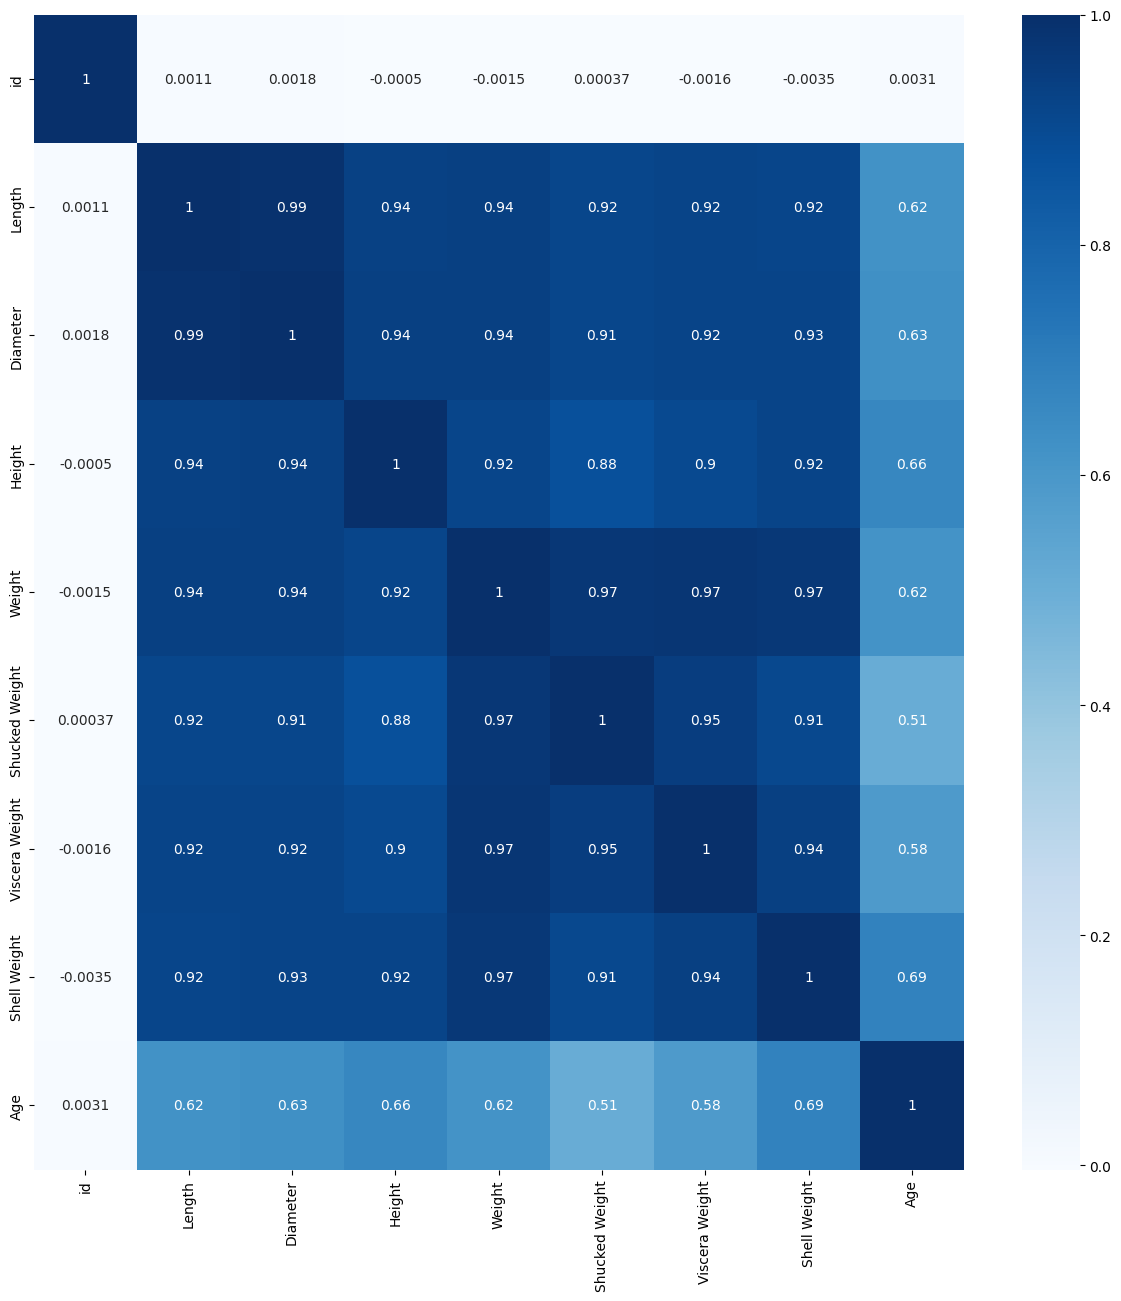

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Blues');

In [14]:
abs(df.corr(numeric_only=True)['Age']).sort_values(ascending=False)

Age               1.000000
Shell Weight      0.685442
Height            0.663520
Diameter          0.630463
Length            0.622534
Weight            0.616414
Viscera Weight    0.584567
Shucked Weight    0.506192
id                0.003106
Name: Age, dtype: float64

## <font color=#C0C0C0> Gereksiz Verileri Silme İşlemi Yapıyoruz - We Delete Unnecessary Data

In [15]:
df=df.drop('id',axis=1)
df.head(1)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,0.825,0.6375,0.225,5.613201,2.069513,1.587572,1.70097,6.0


## <font color=#1cfc03> Aykırı Değer - Outlier

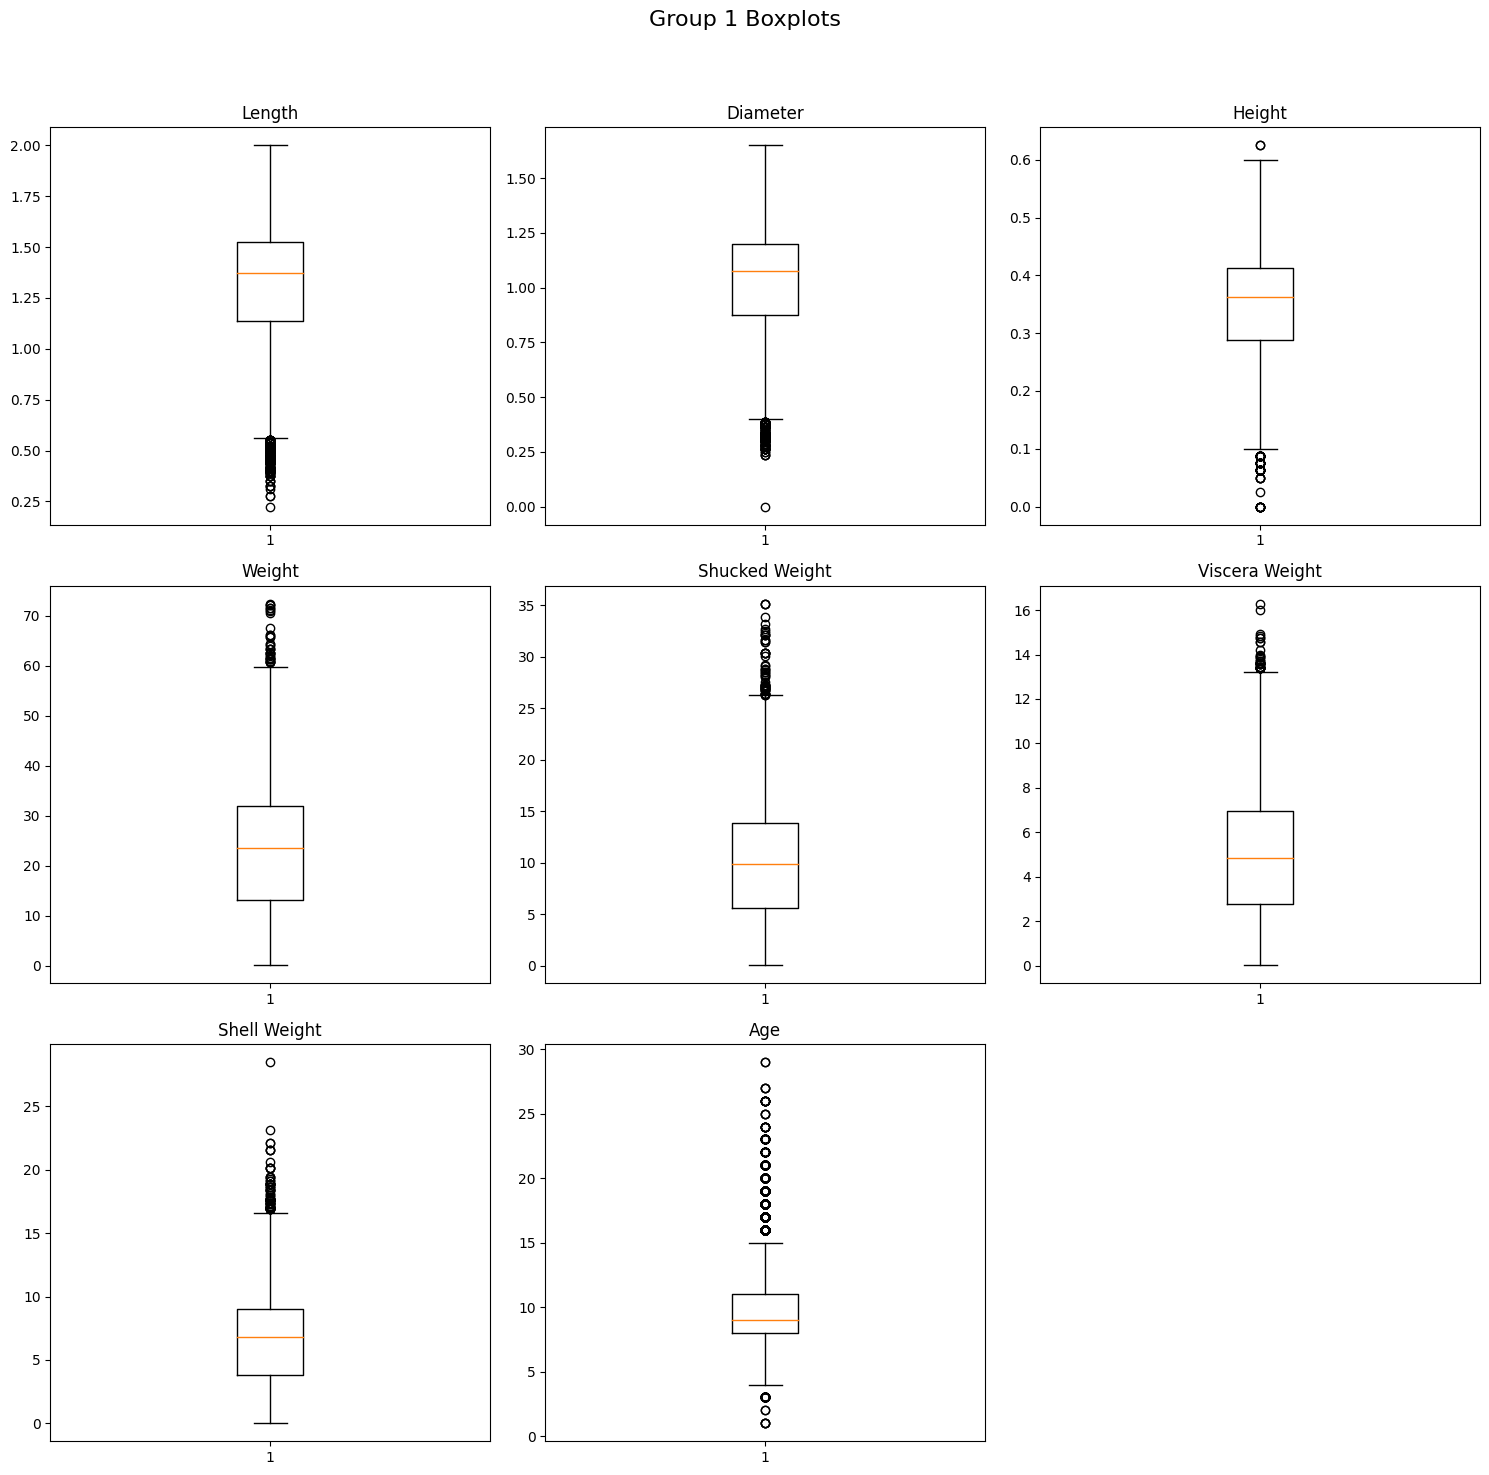

In [16]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns  
# TR = Veri setindeki tüm sayısal sütunları seçer  
# EN = Selects all numeric columns in the dataset

num_cols = len(numeric_cols)  
# TR = Sayısal sütunların toplam sayısını hesaplar  
# EN = Calculates the total number of numeric columns

num_plots_per_group = 9  
# TR = Her grup için 9 grafik olacağını belirtir  
# EN = Specifies that each group will contain 9 plots

num_groups = math.ceil(num_cols / num_plots_per_group)  
# TR = Toplam grafikleri 9'luk gruplar halinde kaç grup gerektiğini hesaplar  
# EN = Calculates how many groups of 9 plots are needed for the total columns

for group in range(num_groups):  
    # TR = Her grup için döngü başlatır  
    # EN = Starts a loop for each group

    cols_in_group = numeric_cols[group * num_plots_per_group:(group + 1) * num_plots_per_group]  
    # TR = Her grup için 9 sütun seçer  
    # EN = Selects 9 columns for each group

    num_plots = len(cols_in_group)  
    # TR = Bu gruptaki toplam grafik sayısını hesaplar  
    # EN = Calculates the total number of plots in the group

    rows = math.ceil(num_plots / 3)  
    # TR = Her grafiğin 3 sütun olacak şekilde kaç satırda yer alacağını belirler  
    # EN = Determines how many rows are needed for 3 columns of plots

    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))  
    # TR = Grafik alt pencereleri (subplots) oluşturur  
    # EN = Creates the subplots for the group

    axs = axs.flatten() if num_plots > 1 else [axs]  
    # TR = Grafik pencerelerini düzleştirir (eğer tek değilse)  
    # EN = Flattens the plot axes (if there’s more than one)

    for i, col in enumerate(cols_in_group):  
        # TR = Her sütun için döngü başlatır  
        # EN = Loops through each column in the group

        axs[i].boxplot(df[col].dropna())  
        # TR = Veri setindeki ilgili sütunun aykırı değerlerini gösteren kutu grafiği oluşturur  
        # EN = Creates a boxplot for the column to show outliers

        axs[i].set_title(col)  
        # TR = Her grafiğe başlık ekler  
        # EN = Adds a title to each plot

    for i in range(num_plots, len(axs)):  
        # TR = Eğer tüm grafikler kullanılmadıysa, fazla olanları gizler  
        # EN = Hides any unused axes if there are fewer plots than subplots

        axs[i].set_visible(False)  

    plt.suptitle(f'Group {group + 1} Boxplots', fontsize=16)  
    # TR = Grup başlığı ekler  
    # EN = Adds a title for the group of boxplots

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    # TR = Grafiklerin düzenli görünmesini sağlar  
    # EN = Ensures the layout is clean and well-organized

In [17]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns  
# TR = Veri setindeki sayısal sütunları (float64 ve int64 türündeki sütunları) seçer  
# EN = Selects numeric columns from the dataset (float64 and int64 types)

for col in numeric_cols:  
    # TR = Her bir sayısal sütun için döngü başlatır  
    # EN = Loops through each numeric column

    percentile_94 = df[col].quantile(0.94)  
    # TR = Sütundaki 94. yüzdelik dilim değerini hesaplar  
    # EN = Calculates the 94th percentile value for the column

    outlier_count = (df[col] > percentile_94).sum()  
    # TR = 94. yüzdelik dilimden büyük olan değerlerin sayısını bulur  
    # EN = Counts how many values are greater than the 94th percentile

    total_rows = len(df)  
    # TR = Veri setindeki toplam satır sayısını alır  
    # EN = Gets the total number of rows in the dataset

    if outlier_count < total_rows:  
        # TR = Eğer aykırı değer sayısı toplam satır sayısından azsa  
        # EN = If the outlier count is less than the total number of rows

        df = df[df[col] <= percentile_94]  
        # TR = 94. yüzdelik dilimden küçük veya eşit olan değerleri tutarak veri setini filtreler  
        # EN = Filters the dataset to keep only values less than or equal to the 94th percentile

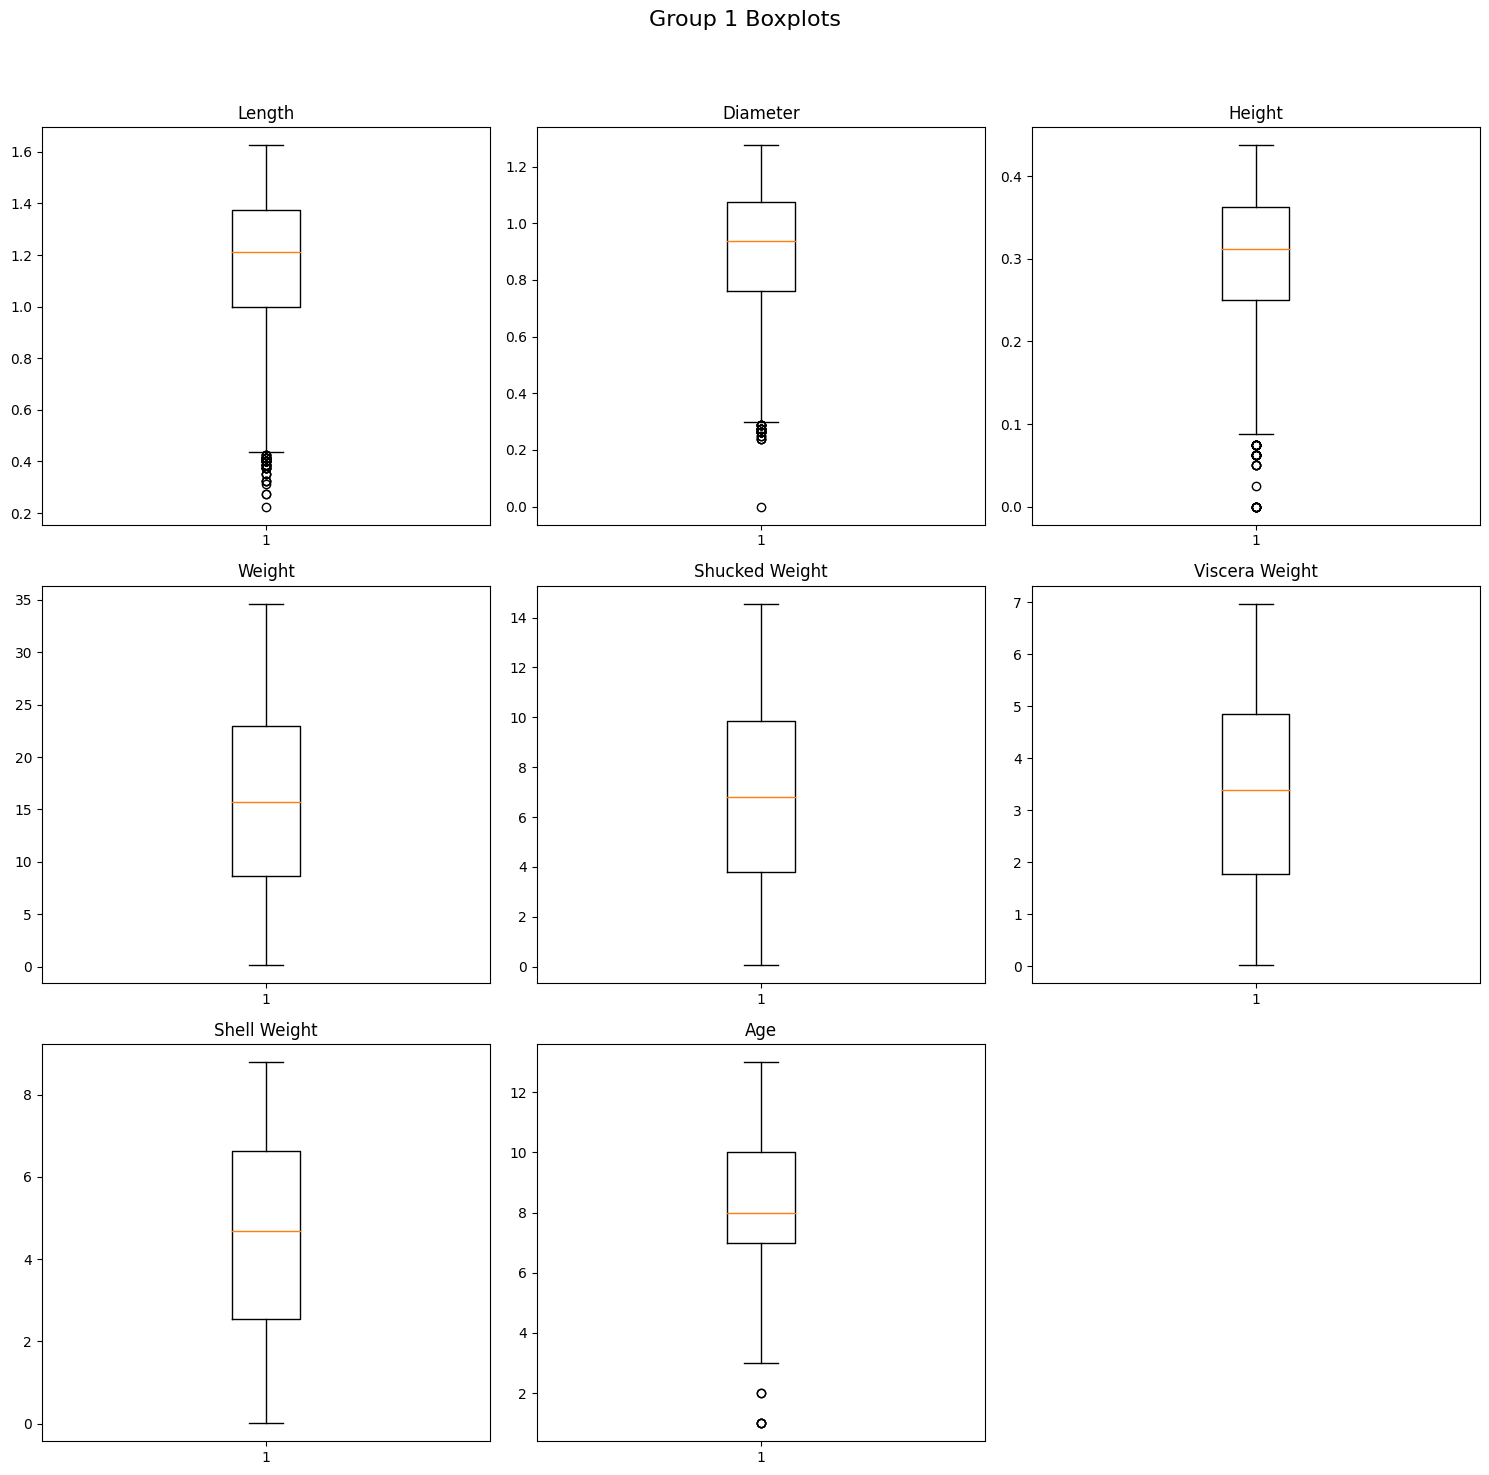

In [18]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

num_cols = len(numeric_cols)
num_plots_per_group = 9
num_groups = math.ceil(num_cols / num_plots_per_group)

for group in range(num_groups):
    cols_in_group = numeric_cols[group * num_plots_per_group:(group + 1) * num_plots_per_group]
    num_plots = len(cols_in_group)
    rows = math.ceil(num_plots / 3)
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axs = axs.flatten() if num_plots > 1 else [axs]

    for i, col in enumerate(cols_in_group):
        axs[i].boxplot(df[col].dropna())
        axs[i].set_title(col)

    for i in range(num_plots, len(axs)):
        axs[i].set_visible(False)  

    plt.suptitle(f'Group {group + 1} Boxplots', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

## <font color='#ff4d00'> Boşluk Varsa Doldurmaya, Düzeltilecek Kısım Varsa Düzeltmeye Başladık - If there is a gap, we started to fill it and if there is a part to be corrected, we started to correct it.

In [19]:
df.columns = df.columns.str.replace(r'[\s\.]', '_', regex=True)

In [20]:
df.isnull().sum().sort_values(ascending=False)

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked_Weight    0
Viscera_Weight    0
Shell_Weight      0
Age               0
dtype: int64

### <font color=#ff2400> Sex Sütuna Bakıyoruz - We Look at the Column Sex

In [21]:
df['Sex']=df['Sex'].map({'I':0,'F':1,'M':2}).astype(int)

In [22]:
df.isnull().sum().sort_values(ascending=False)

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked_Weight    0
Viscera_Weight    0
Shell_Weight      0
Age               0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9406 entries, 0 to 14997
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             9406 non-null   int32  
 1   Length          9406 non-null   float64
 2   Diameter        9406 non-null   float64
 3   Height          9406 non-null   float64
 4   Weight          9406 non-null   float64
 5   Shucked_Weight  9406 non-null   float64
 6   Viscera_Weight  9406 non-null   float64
 7   Shell_Weight    9406 non-null   float64
 8   Age             9406 non-null   float64
dtypes: float64(8), int32(1)
memory usage: 698.1 KB


## <font color=#e0c510> Verileri Görşelleştirme - Visualizing Data me

In [24]:
#for column in df.columns:  
    # TR = Verideki her bir sütun için döngü başlatılıyor  
    # EN = Loops through each column in the dataframe

#    print(f"\nSütun: {column}")  
    # TR = Sütun ismi ekrana yazdırılıyor  
    # EN = Prints the column name

#    unique = df[column].dropna().unique()  
    # TR = NaN değerleri düşürerek benzersiz değerler elde ediliyor  
    # EN = Gets the unique values after dropping NaN values

#    if pd.api.types.is_numeric_dtype(df[column]):  
        # TR = Eğer sütundaki değerler sayısal ise, değerler sıralanıyor  
        # EN = If the column is of numeric type, the unique values are sorted
#        unique = sorted(unique)

#    print(f"Unique Değerler: {unique}")  
    # TR = Benzersiz değerler ekrana yazdırılıyor  
    # EN = Prints the unique values


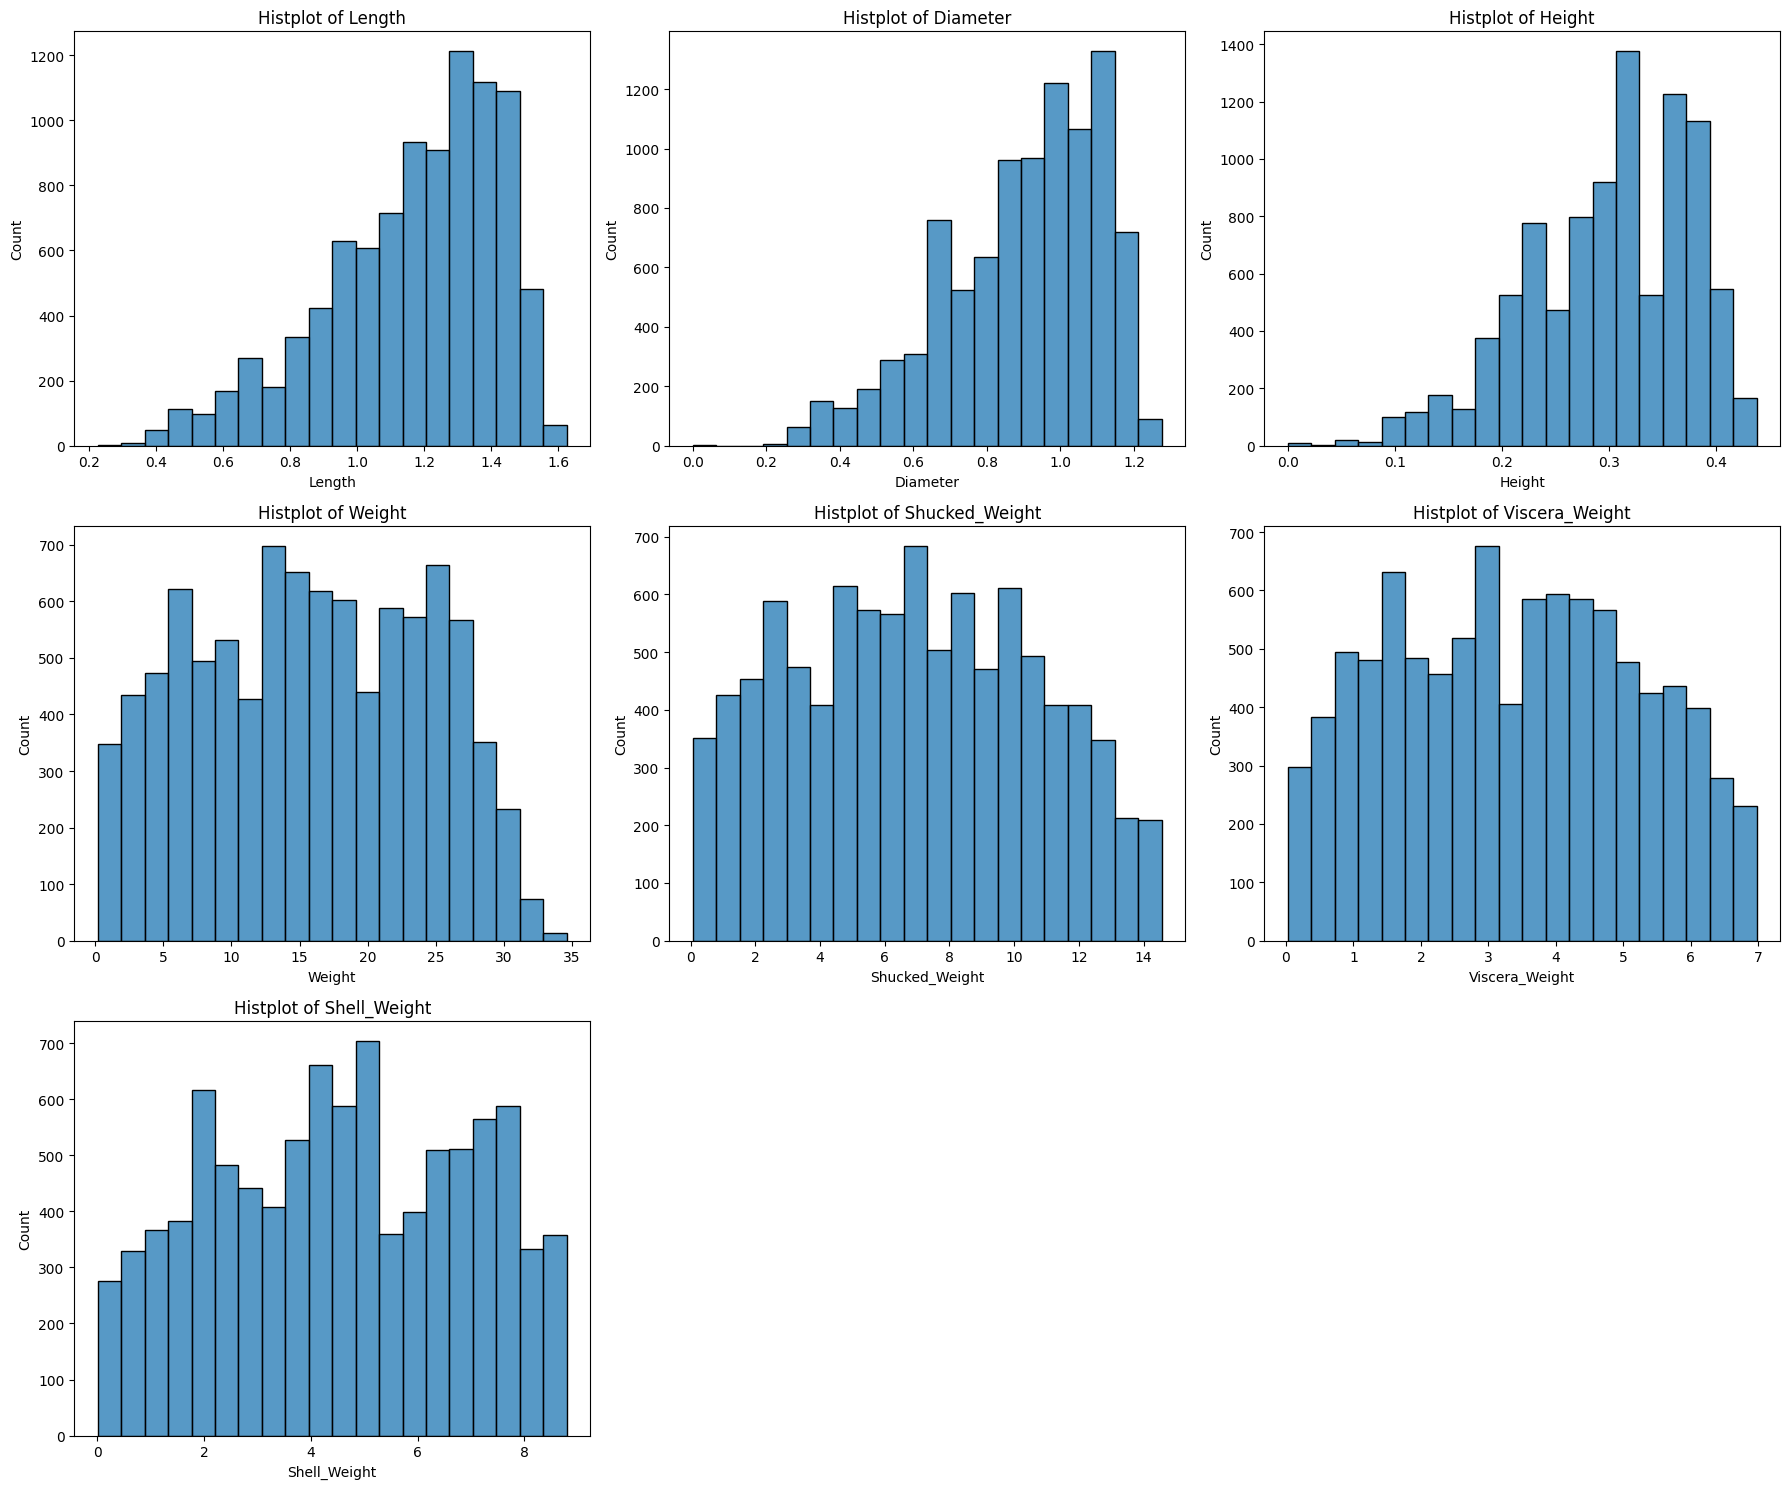

In [25]:
excluded_columns = ['Sex','Age']  
# TR = excluded_columns'ma eşitlenmiş sütunları görselleştirmeden hariç tutuyoruz.
# EN = We exclude columns equal to excluded_columns from the visualization.

columns = [col for col in df.columns if col not in excluded_columns]
# TR = (in df.columns) df DataFrame içindeki (col for col)her sütuna bak.
# TR = (if col not in excluded_columns) excluded_columns değişkeninin içindeki sütun adlarına bakma.

# EN = (in df.columns) Look at each column in df DataFrame (col for col).
# EN = (if col not in excluded_columns) Look at the column names in the excluded_columns variable.

num_columns = len(columns)
# TR = sütun sayısını okuyup, num_columns değişkenine atadım.
# EN = I read the number of columns and assigned it to the num_columns variable.

fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(18, (num_columns // 3 + 1) * 5))
# TR = nrows=(num_columns // 3) + 1: Bu, oluşturulacak alt grafiklerin (subplot'ların) satır sayısını belirler.
# TR = num_columns // 3, toplam sütun sayısının 3'e bölünmesiyle elde edilen tam sayı değerdir. + 1 ise, sütun sayısı 3'e tam bölünmüyorsa ekstra bir satır ekler.
# TR = ncols=3: Bu, her satırda kaç tane alt grafik olacağını belirler. Bu örnekte, her satırda 3 alt grafik olacak şekilde ayarlanmıştır.  
# TR = figsize=(18, (num_columns // 3 + 1) * 5): Bu, oluşturulacak figürün (grafiklerin tümünün bulunduğu büyük alanın) boyutlarını ayarlar.
# TR = figsize parametresi, genişlik ve yükseklik değerlerini (18, (num_columns // 3 + 1) * 5) şeklinde alır. 
# TR = Genişlik 18 inç, yükseklik ise her satır için 5 inç olacak şekilde hesaplanır.

# EN = nrows=(num_columns // 3) + 1: This determines the number of rows of subplots to be created.
# EN = num_columns // 3 is the integer value obtained by dividing the total number of columns by 3. + 1 adds an extra row if the column count is not perfectly divisible by 3.
# EN = ncols=3: This determines how many subplots will be in each row. In this example, there will be 3 subplots per row.
# EN = figsize=(18, (num_columns // 3 + 1) * 5): This sets the size of the figure (the large area containing all the plots).
# EN = The figsize parameter takes the width and height values as (18, (num_columns // 3 + 1) * 5).
# EN = The width is 18 inches, and the height is calculated as 5 inches per row.


for i, column in enumerate(columns):  
    row = i // 3  
    # TR = Her sütunun hangi satırda gösterileceğini hesaplar (3 sütundan birinde)  
    # EN = Calculates which row each column should be displayed in (one of three columns)

    col = i % 3  
    # TR = Her sütunun hangi sütunda gösterileceğini hesaplar (0'dan 2'ye kadar)  
    # EN = Calculates which column each plot should be placed in (from 0 to 2)

    sns.histplot(data=df,x=column, bins=20, ax=axes[row, col])  
    # TR = (data=df) Veriyi df adlı DataFrame alacak.
    # TR = (x=column) column değişkenindeki sütunları alıp yatay eksenine eşitleyecek
    # TR = (bins=20) Veri ayarını 20 eşit genişlikte bölüme ayırmış olursunuz. 
    # TR = (ax=axes[row, col]) Tablonun yukarıdan ve soldan kaçıncı sırada duracağını beliler
    
    # EN = (data=df) Will take the data from the DataFrame named df.
    # EN = (x=column) Will take the columns in the column variable and assign them to the x-axi
    # EN = (bins=20) You will divide the data set into 20 equally wide sections.
    # EN = (ax=axes[row, col]) Specifies the position in the grid, indicating which row and column it will be placed in.


    axes[row, col].set_title(f'Histplot of {column}')  
    # TR = Grafiğin başlığını, ilgili sütun adı ile ayarlar  
    # EN = Sets the title of the plot to the name of the column


for j in range(i+1, len(axes.flat)):  
    # TR = Kullanılmayan alt grafikler (subplots) siliniyor  
    # EN = Removing unused subplots

    fig.delaxes(axes.flat[j])  
    # TR = Belirtilen alt grafiği (subplot) siler  
    # EN = Deletes the specified subplot from the figure

plt.tight_layout()  
# TR = Grafiklerin düzenli görünmesi için yerleşim ayarlarını yapar  
# EN = Adjusts the layout for a tidy appearance

plt.show()  
# TR = Grafiği ekranda gösterir  
# EN = Displays the plot on the screen

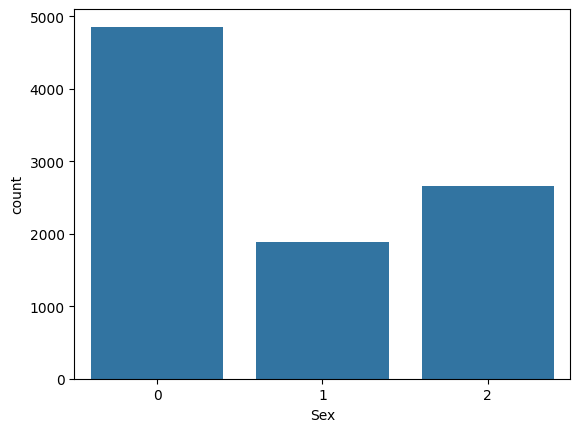

In [26]:
sns.countplot(x='Sex', data=df);
# TR = Kategorik verilerin her bir sınıfındaki gözlem sayısını görselleştirmek için kullanılır ve her kategorinin frekansını çubuklarla gösterir.
# EN = It is used to visualize the number of observations in each class of categorical data and shows the frequency of each category with bars.

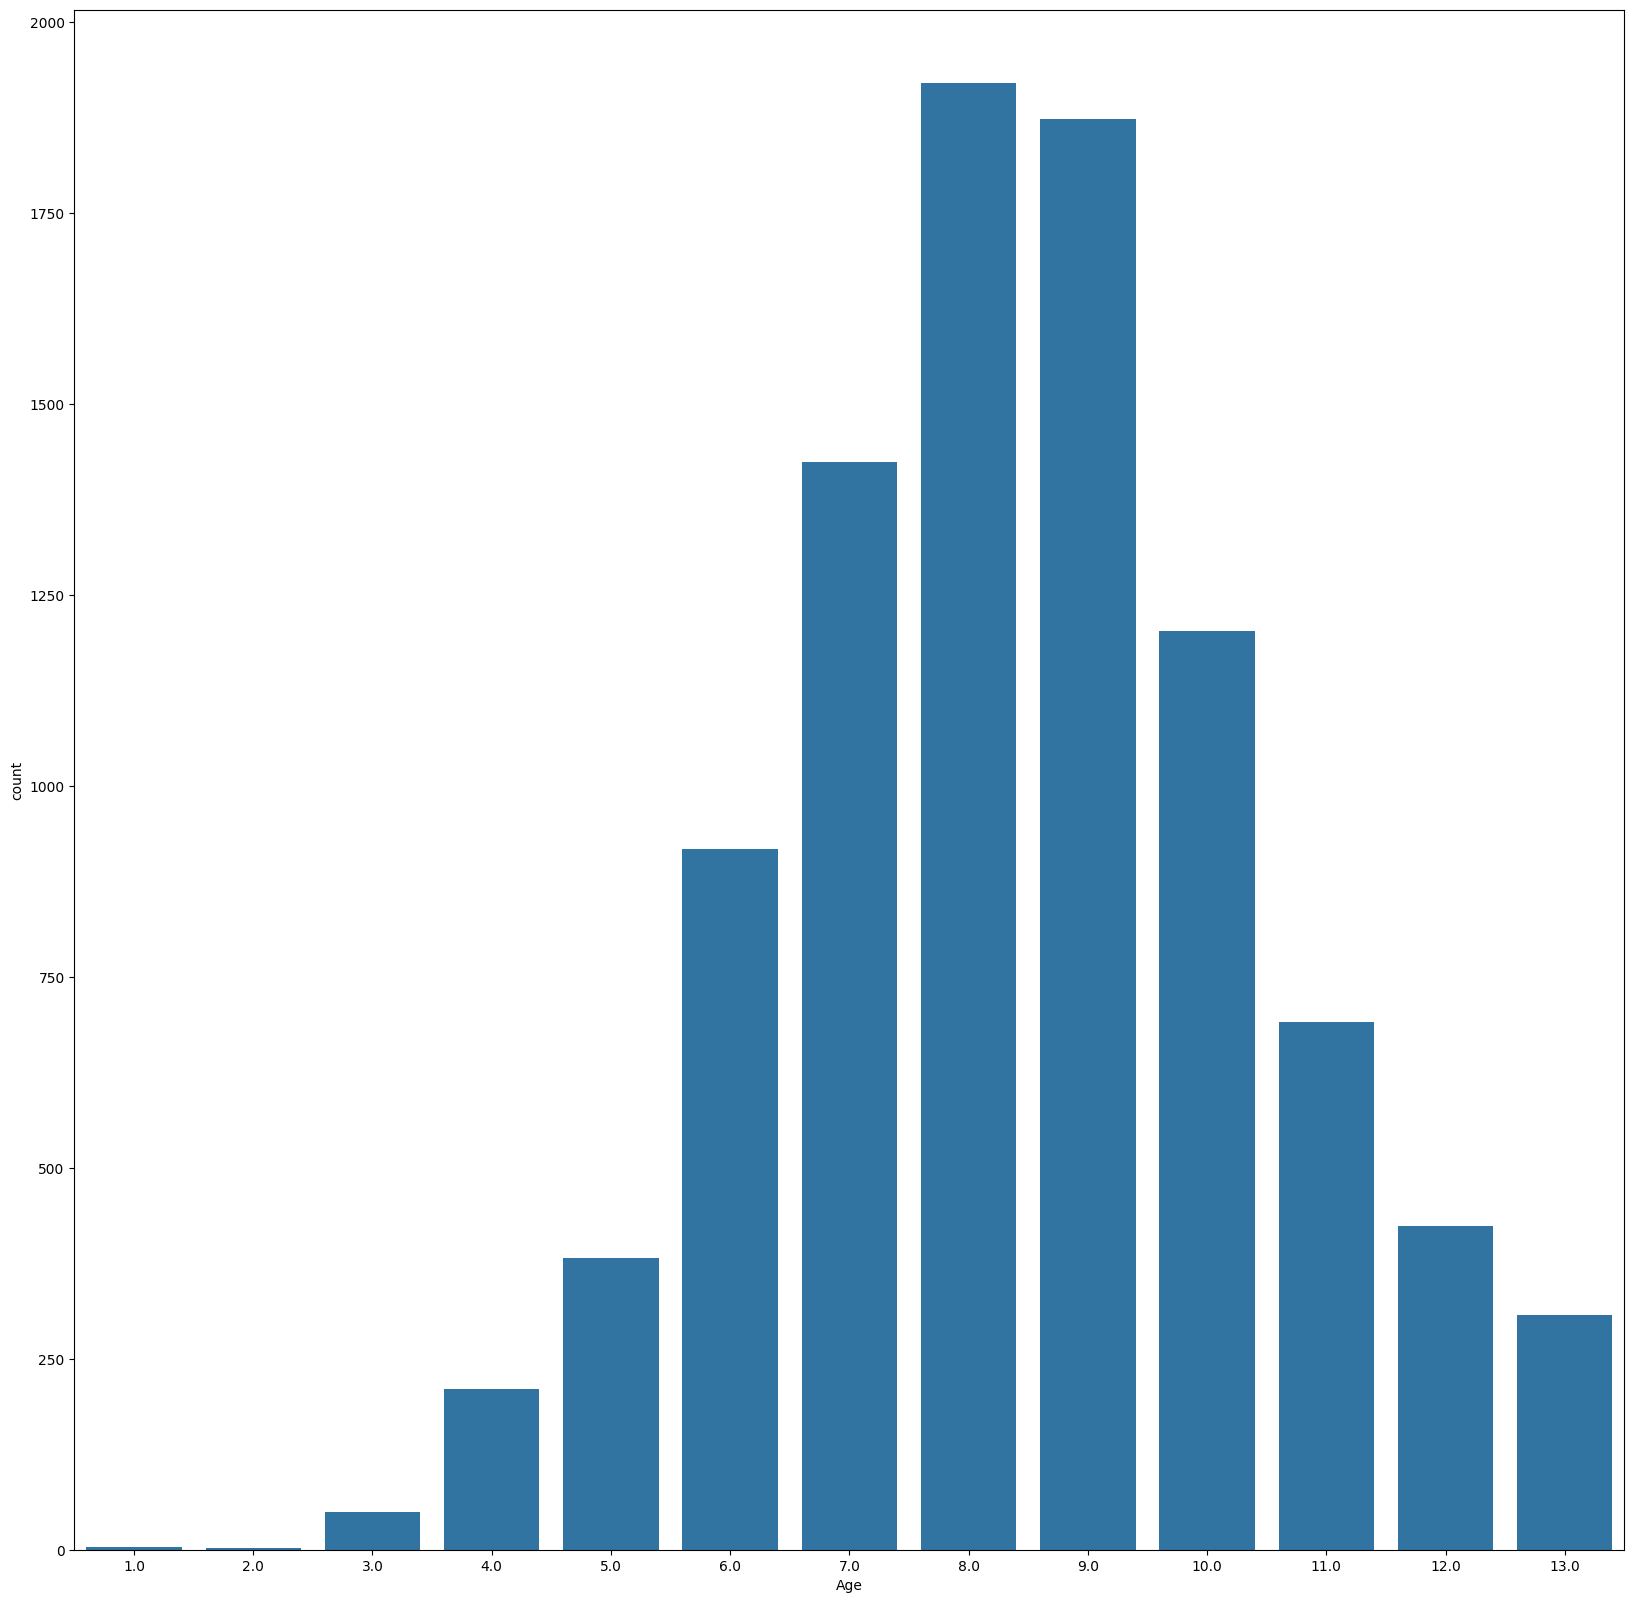

In [27]:
plt.figure(figsize=(20,20))
sns.countplot(x='Age', data=df);

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling 

In [28]:
x=df.drop('Age',axis=1)
y=df[['Age']]

In [29]:
x=pd.get_dummies(x,drop_first=True)
# Tr =  kategorik değişkenlerin sayısal değişkenlere dönüştürülmesi için kullanılır. 
# En = It is used to convert categorical variables into numerical variables.

In [30]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [31]:
scaler = MinMaxScaler()
# TR = Girdilerin belirli bir aralıkta olması performansı artırır. Bu nedenle MinMaxScaler ile verileri 0 ile 1 arasında normalize ediyoruz.
# EN = Having inputs within a certain range improves performance. Therefore, we normalize the data between 0 and 1 with MinMaxScaler.

x_train = scaler.fit_transform(x_train)
# TR = Verileri ölçekleyerek, modelin daha hızlı ve etkili öğrenmesini sağlamak için tüm özellikleri aynı aralığa getiriyoruz.
# EN = By scaling the data, we bring all the features into the same range to allow the model to learn faster and more effectively.

x_test = scaler.transform(x_test)
# TR = Test verilerini eğitimde kullanılan aynı ölçekle dönüştürerek modelin test verileri üzerinde doğru tahminler yapmasını sağlar.
# EN = It enables the model to make accurate predictions on the test data by transforming the test data to the same scale used in training.

In [32]:
model=Sequential()
model.add(Dense(256,activation='relu',input_dim=x_train.shape[1]))
# TR = Bu katman, tüm giriş nöronlarına bağlantı kurar ve her nöronun ağırlıklarını öğrenir. 256 nöron var.
# Aktivasyon fonksiyonunu ReLU (Rectified Linear Unit) olarak ayarlar. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürür ve pozitif değerleri olduğu gibi bırakır.
# EN = This layer connects all input neurons and learns the weights of each neuron. There are 256 neurons.
# Sets the activation function to ReLU (Rectified Linear Unit). The ReLU function converts negative values ​​to zero and leaves positive values ​​as is.

model.add(BatchNormalization())
# TR = Bu katman, modelin eğitim sürecini daha stabil hale getirmek için kullanılır.
# EN = This layer is used to make the training process of the model more stable.

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])  
# TR = Modelin kayıp fonksiyonu olarak 'mse' (ortalama kare hatası), optimizer olarak 'adam' ve performans metriği olarak 'mae' (ortalama mutlak hata) kullanılarak derlenmesini sağlar  
# EN = Compiles the model using 'mse' (mean squared error) as the loss function, 'adam' as the optimizer, and 'mae' (mean absolute error) as the performance metric

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 32 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 32.

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 63.3593 - mae: 7.8018 - val_loss: 17.9677 - val_mae: 3.9179
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.6755 - mae: 3.0008 - val_loss: 1.7280 - val_mae: 1.0257
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8109 - mae: 1.0089 - val_loss: 1.5463 - val_mae: 0.9755
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6665 - mae: 0.9801 - val_loss: 1.4999 - val_mae: 0.9288
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6578 - mae: 0.9861 - val_loss: 1.6057 - val_mae: 0.9660
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6312 - mae: 0.9766 - val_loss: 1.6357 - val_mae: 1.0239
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6522 - mae: 0.9768 - val_loss: 1.5384 - val_mae: 0.9356
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6542 - mae: 0.9780 - val_loss: 1.5101 - val_mae: 0.9499
Epoch 9/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,549 (549.02 KB)

 Trainable params: 46,529 (181.75 KB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 93,060 (363.52 KB)

In [34]:
test_loss, test_acc = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test doğruluğu: {test_acc:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 1.3918 - mae: 0.9173
Test doğruluğu: 0.9323


In [35]:
pred=model.predict(x_test)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik. 
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred.

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [36]:
r2_score(y_test,pred) 
# TR = Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır ve arasındaki farkı bul. 
# EN = Compare this with the actual (y_test) value and the predicted (pred) values ​​and find the difference between them.

0.645889163017273

In [37]:
mean_squared_error(y_test,pred)**.5 
# TR = Burada, Root Mean Square Error bulduk. Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır arasındaki farkı bul ve **.5 ile karekökünü al.
# EN = Here, we found Root Mean Square Error. Compare this with the actual (y_test) value and the predicted (pred) values, find the difference and take the square root of **.5.

1.1981750499516224

In [38]:
mean_absolute_error(y_test,pred)
# TR = mean_absolute_error ile (y_test,pred) kullanarak değerini hesaplama. 
# EN = Calculating the value of mean_absolute_error using (y_test,pred).

0.9322584150448109

In [39]:
residuals=y_test-pred

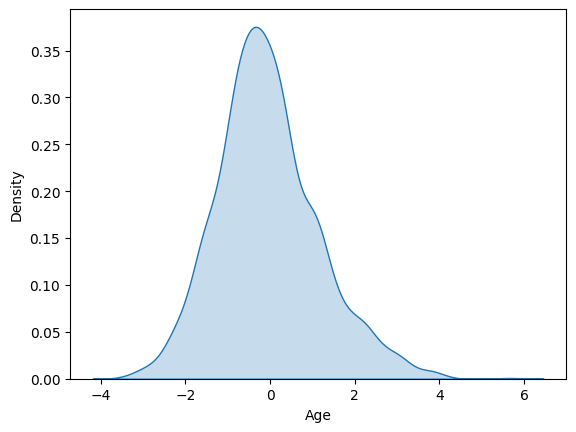

In [40]:
sns.kdeplot(x=residuals['Age'],fill=True);
# TR = Veri dağılımını pürüzsüz bir şekilde tahmin etmek için kullanılan bir yoğunluk grafiğidir. Kernel Yoğunluk Tahmini (KDE) ile verinin altında yatan olasılık dağılımını görselleştirir.
# EN = It is a density plot used to smoothly estimate the distribution of data. It visualizes the underlying probability distribution of data using Kernel Density Estimation (KDE).

In [41]:
loss_f=pd.DataFrame(history.history)

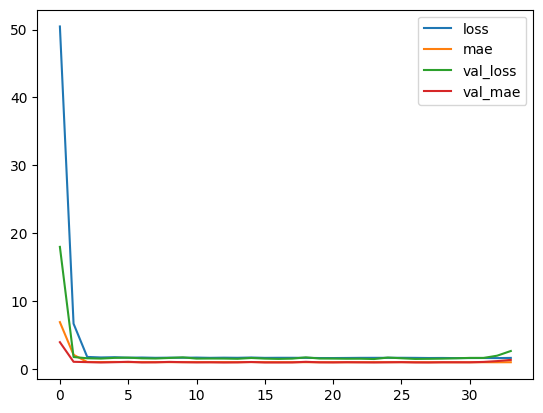

In [42]:
loss_f.plot();

In [46]:
pickle.dump(model,open('Yengeç_Yaş.pkl','wb'))